In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import io
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from Levenberg_Marquardt import LevenbergMarquardt

# Read mnist data from the mat file
mnist_data = io.loadmat("./mnist2.mat")
imgs_train = mnist_data['imgs_train']
imgs_test = mnist_data['imgs_test']
labels_train = np.squeeze(mnist_data['labels_train'])
labels_test = np.squeeze(mnist_data['labels_test'])

# Change to 60000 * 20 * 20
imgs_train = imgs_train.transpose(2, 0, 1)
imgs_test = imgs_test.transpose(2, 0, 1)

# Filter samples labeled 1 and 7 in imgs_train
train_filter = np.isin(labels_train, [1, 7])
imgs_train_17 = imgs_train[train_filter]
labels_train_17 = labels_train[train_filter]

# Filter samples labeled 1 and 7 in imgs_test
test_filter = np.isin(labels_test, [1, 7])
imgs_test_17 = imgs_test[test_filter]
labels_test_17 = labels_test[test_filter]

print(f"Filtered training data shape: {imgs_train_17.shape}")
print(f"Filtered training labels shape: {labels_train_17.shape}")
print(f"Filtered test data shape: {imgs_test_17.shape}")
print(f"Filtered test labels shape: {labels_test_17.shape}")

# Save 20 components
NPCA = 20

def do_pca(dataset, n_components):
    data_flattened = dataset.reshape(dataset.shape[0], -1)
    print(f"Data shape before PCA: {data_flattened.shape}")
    
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(data_flattened)
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data_standardized)
    print(f"Data shape after PCA: {data_pca.shape}")
    
    return data_pca

X_train = do_pca(imgs_train_17, NPCA)
lbl_train = labels_train_17

X_test = do_pca(imgs_test_17, NPCA)
lbl_test = labels_test_17

Filtered training data shape: (13007, 20, 20)
Filtered training labels shape: (13007,)
Filtered test data shape: (2163, 20, 20)
Filtered test labels shape: (2163,)
Data shape before PCA: (13007, 400)
Data shape after PCA: (13007, 20)
Data shape before PCA: (2163, 400)
Data shape after PCA: (2163, 20)


In [3]:
# Define the quadratic loss and functions for optimization
def logloss_quadratic(X, y, w):
    return 0.5 * np.sum((np.log(1. + np.exp(-myquadratic(X, y, w))))**2)

def Res_and_Jac(X, y, w):
    aux = np.exp(-myquadratic(X, y, w))
    r = np.log(1. + aux)
    a = -aux / (1. + aux)
    n, d = np.shape(X)
    d2 = d * d
    ya = y * a
    qterm = np.zeros((n, d2))
    for k in range(n):
        xk = X[k, :]
        xx = np.outer(xk, xk)
        qterm[k, :] = np.reshape(xx, (np.size(xx),))
    J = np.concatenate((qterm, X, np.ones((n, 1))), axis=1)
    for k in range(n):
        J[k, :] = J[k, :] * ya[k]
    return r, J

def myquadratic(X, y, w):
    d = np.size(X, axis=1)
    d2 = d * d
    W = np.reshape(w[:d2], (d, d))
    v = w[d2:d2 + d]
    b = w[-1]
    qterm = np.diag(X @ W @ np.transpose(X))
    q = y * qterm + (np.outer(y, np.ones((d,))) * X) @ v + y * b
    return q

# Define the smooth loss function
def new_loss_function(X, y, w, lam):
    n = X.shape[0]
    regularization = lam / 2 * np.linalg.norm(w)**2
    return (1 / n) * np.sum((np.log(1. + np.exp(-myquadratic(X, y, w))))) + regularization

In [20]:
def stochastic_gradient_descent(X, y, w, lam, batch_size, step_size, max_epochs, tol, step_size_decay=None):
    n = X.shape[0]
    Loss_vals = []
    gradnorm_vals = []
    
    for epoch in range(max_epochs):
        # Shuffle the data
        indices = np.arange(n)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for i in range(0, n, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]
            
            # Compute the gradient
            r, J = Res_and_Jac(X_batch, y_batch, w)
            grad = J.T @ r + lam * w
            
            # Update the weights
            w = w - step_size * grad
            
            # Compute the loss and gradient norm
            loss = new_loss_function(X_batch, y_batch, w, lam)
            grad_norm = np.linalg.norm(grad)
            
            if grad_norm < tol:
                break
            
        Loss_vals.append(loss)
        gradnorm_vals.append(grad_norm)
        print(f"Epoch: {epoch},\t Loss: {loss},\t Gradient Norm: {grad_norm}")
        
        # Apply step size decay if specified
        if step_size_decay:
            step_size *= step_size_decay
        
        if grad_norm < tol:
            break
    
    return w, epoch + 1, np.array(Loss_vals), np.array(gradnorm_vals)

# Parameters for SGD optimization
batch_size = 32
max_epochs = 100
step_size_decay = 0.99
tol = 1e-4
step_size = 1e-3
lam = 1e-4
w_init = np.zeros((NPCA * NPCA + NPCA + 1))

# Run the stochastic gradient descent method
w_sgd, epochs_sgd, Loss_vals_sgd, gradnorm_vals_sgd = stochastic_gradient_descent(X_train, lbl_train, w_init, lam, batch_size,step_size, max_epochs, tol, step_size_decay)

Epoch: 0,	 Loss: 0.0006475977911954052,	 Gradient Norm: 0.0003598882939788353
Epoch: 1,	 Loss: 0.0006475456059799481,	 Gradient Norm: 0.00035987379293135445
Epoch: 2,	 Loss: 0.0006474939467590322,	 Gradient Norm: 0.00035985943746991394
Epoch: 3,	 Loss: 0.0006474428081899579,	 Gradient Norm: 0.0003598452261271777
Epoch: 4,	 Loss: 0.0006473921849851008,	 Gradient Norm: 0.00035983115745071015
Epoch: 5,	 Loss: 0.0006473420719113427,	 Gradient Norm: 0.0003598172300028263
Epoch: 6,	 Loss: 0.0006472924637894866,	 Gradient Norm: 0.000359803442360438
Epoch: 7,	 Loss: 0.0006472433554936853,	 Gradient Norm: 0.00035978979311490275
Epoch: 8,	 Loss: 0.0006471947419508772,	 Gradient Norm: 0.00035977628087187645
Epoch: 9,	 Loss: 0.0006471466181402285,	 Gradient Norm: 0.00035976290425116485
Epoch: 10,	 Loss: 0.0006470989790925805,	 Gradient Norm: 0.0003597496618865791
Epoch: 11,	 Loss: 0.000647051819889904,	 Gradient Norm: 0.00035973655242579086
Epoch: 12,	 Loss: 0.0006470051356647574,	 Gradient Norm: 

In [17]:
# Define the Nesterov method for optimization
def nesterov_method(X, y, w_init, lam, step_size, max_iters, tol):
    v = np.zeros_like(w_init)
    w = w_init.copy()
    Loss_vals = []
    gradnorm_vals = []
    
    for t in range(1, max_iters + 1):
        mu_k = 1 - 3 / (5 + t)  # Dynamic momentum term
        w_ahead = w + mu_k * v
        r, J = Res_and_Jac(X, y, w_ahead)
        grad = J.T @ r + lam * w_ahead
        
        v = mu_k * v - step_size * grad
        w = w + v
        
        loss = new_loss_function(X, y, w, lam)
        grad_norm = np.linalg.norm(grad)
        
        print(f"Iteration {t}: Loss = {loss:.6f}, Grad Norm = {grad_norm:.6f}")
        Loss_vals.append(loss)
        gradnorm_vals.append(grad_norm)
        
        if grad_norm < tol:
            break

    return w, Loss_vals, gradnorm_vals

# Parameters for Nesterov optimization
step_size = 0.01
max_iters = 100
tol = 1e-3
lam = 0.1
w_init = np.ones((NPCA * NPCA + NPCA + 1,))

# Run the Nesterov method
w_opt, Loss_vals, gradnorm_vals = nesterov_method(X_train, lbl_train, w_init, lam, step_size, max_iters, tol)

Iteration 1: Loss = 77.362873, Grad Norm = 3356.326929
Iteration 2: Loss = 159.798819, Grad Norm = 5.658956
Iteration 3: Loss = 229.438247, Grad Norm = 6.780823
Iteration 4: Loss = 283.150498, Grad Norm = 7.532830
Iteration 5: Loss = 323.770650, Grad Norm = 8.055050
Iteration 6: Loss = 354.447670, Grad Norm = 8.428020
Iteration 7: Loss = 377.676832, Grad Norm = 8.699808
Iteration 8: Loss = 395.291313, Grad Norm = 8.900372
Iteration 9: Loss = 408.615198, Grad Norm = 9.049129
Iteration 10: Loss = 418.607462, Grad Norm = 9.159104
Iteration 11: Loss = 425.969847, Grad Norm = 9.239297
Iteration 12: Loss = 431.222709, Grad Norm = 9.296090
Iteration 13: Loss = 434.757439, Grad Norm = 9.334112
Iteration 14: Loss = 436.872678, Grad Norm = 9.356792
Iteration 15: Loss = 437.799529, Grad Norm = 9.366712
Iteration 16: Loss = 437.719292, Grad Norm = 9.365853
Iteration 17: Loss = 436.776095, Grad Norm = 9.355757
Iteration 18: Loss = 435.085992, Grad Norm = 9.337639
Iteration 19: Loss = 432.743601, Gr

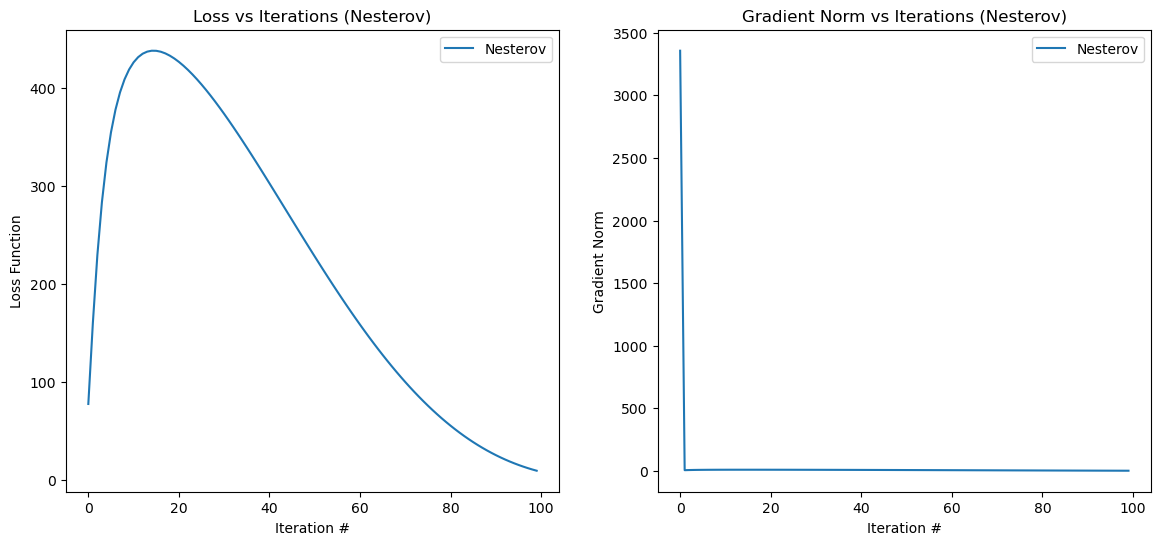

In [18]:
# Plot the loss change and gradient change for the Nesterov method
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Nesterov method
ax1.plot(Loss_vals, label='Nesterov')
ax1.set_title('Loss vs Iterations (Nesterov)')
ax1.set_xlabel('Iteration #')
ax1.set_ylabel('Loss Function')
ax1.legend()

ax2.plot(gradnorm_vals, label='Nesterov')
ax2.set_title('Gradient Norm vs Iterations (Nesterov)')
ax2.set_xlabel('Iteration #')
ax2.set_ylabel('Gradient Norm')
ax2.legend()

plt.show()

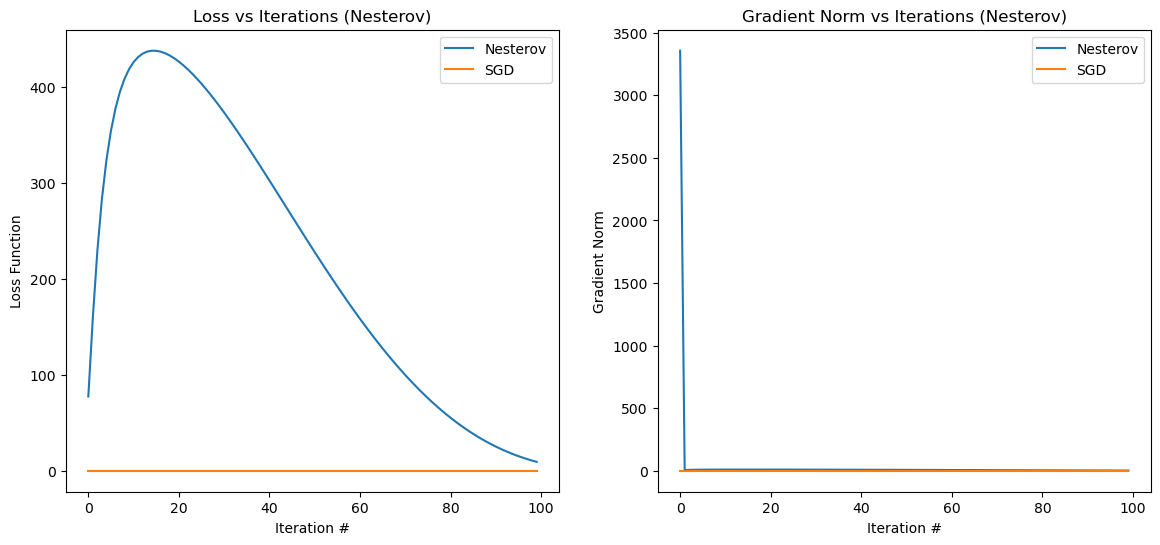

In [21]:
# Plot the loss change and gradient change of the two methods
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Nesterov method
ax1.plot(Loss_vals, label='Nesterov')
ax1.set_title('Loss vs Iterations (Nesterov)')
ax1.set_xlabel('Iteration #')
ax1.set_ylabel('Loss Function')
ax1.legend()

ax2.plot(gradnorm_vals, label='Nesterov')
ax2.set_title('Gradient Norm vs Iterations (Nesterov)')
ax2.set_xlabel('Iteration #')
ax2.set_ylabel('Gradient Norm')
ax2.legend()

# Plot for SGD method
ax1.plot(Loss_vals_sgd, label='SGD')
ax1.legend()

ax2.plot(gradnorm_vals_sgd, label='SGD')
ax2.legend()

plt.show()

In [24]:
def adam_optimizer(X, y, w_init, lam, step_size, max_iters, tol, beta1=0.9, beta2=0.999, epsilon=1e-8):
    w = w_init.copy()
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    Loss_vals = []
    gradnorm_vals = []
    
    for t in range(1, max_iters + 1):
        r, J = Res_and_Jac(X, y, w)
        grad = J.T @ r + lam * w
        
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)
        
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        
        w = w - step_size * m_hat / (np.sqrt(v_hat) + epsilon)
        
        loss = new_loss_function(X, y, w, lam)
        grad_norm = np.linalg.norm(grad)
        
        Loss_vals.append(loss)
        gradnorm_vals.append(grad_norm)
        
        print(f"Iteration {t}: Loss = {loss:.6f}, Grad Norm = {grad_norm:.6f}")
        
        if grad_norm < tol:
            break
    
    return w, Loss_vals, gradnorm_vals

def stochastic_adam_optimizer(X, y, w_init, lam, step_size, max_epochs, batch_size, tol, beta1=0.9, beta2=0.999, epsilon=1e-8):
    w = w_init.copy()
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    Loss_vals = []
    gradnorm_vals = []
    
    n = X.shape[0]
    
    for epoch in range(max_epochs):
        indices = np.arange(n)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for i in range(0, n, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]
            
            r, J = Res_and_Jac(X_batch, y_batch, w)
            grad = J.T @ r + lam * w
            
            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad ** 2)
            
            m_hat = m / (1 - beta1 ** (epoch + 1))
            v_hat = v / (1 - beta2 ** (epoch + 1))
            
            w = w - step_size * m_hat / (np.sqrt(v_hat) + epsilon)
            
            loss = new_loss_function(X_batch, y_batch, w, lam)
            grad_norm = np.linalg.norm(grad)
            
            if grad_norm < tol:
                break
        
        Loss_vals.append(loss)
        gradnorm_vals.append(grad_norm)
        
        print(f"Epoch {epoch + 1}: Loss = {loss:.6f}, Grad Norm = {grad_norm:.6f}")

        if grad_norm < tol:
            break
    
    return w, Loss_vals, gradnorm_vals

In [ ]:
# Parameters for Adam optimization
step_size = 0.001
max_iters = 100
tol = 1e-4
lam = 1e-4
w_init = np.zeros((NPCA * NPCA + NPCA + 1))

# Run the Deterministic Adam method
w_adam, Loss_vals_adam, gradnorm_vals_adam = adam_optimizer(X_train, lbl_train, w_init, lam, step_size, max_iters, tol)

In [25]:
# Parameters for Stochastic Adam optimization
batch_size = 32
max_epochs = 100

# Run the Stochastic Adam method
w_stochastic_adam, Loss_vals_stochastic_adam, gradnorm_vals_stochastic_adam = stochastic_adam_optimizer(X_train, lbl_train, w_init, lam, step_size, max_epochs, batch_size, tol)

Epoch 1: Loss = 0.029552, Grad Norm = 6.868146
Epoch 2: Loss = 0.008370, Grad Norm = 1.763850
Epoch 3: Loss = 0.034606, Grad Norm = 5.353646
Epoch 4: Loss = 0.035322, Grad Norm = 5.014143
Epoch 5: Loss = 0.015011, Grad Norm = 1.096201
Epoch 6: Loss = 0.030202, Grad Norm = 3.126941
Epoch 7: Loss = 0.017585, Grad Norm = 1.222940
Epoch 8: Loss = 0.006034, Grad Norm = 0.412631
Epoch 9: Loss = 0.014014, Grad Norm = 0.941428
Epoch 10: Loss = 0.009111, Grad Norm = 0.617839
Epoch 11: Loss = 0.009565, Grad Norm = 0.313770
Epoch 12: Loss = 0.002616, Grad Norm = 0.118458
Epoch 13: Loss = 0.005285, Grad Norm = 0.305280
Epoch 14: Loss = 0.017774, Grad Norm = 0.886704
Epoch 15: Loss = 0.009118, Grad Norm = 0.430627
Epoch 16: Loss = 0.008854, Grad Norm = 0.354255
Epoch 17: Loss = 0.008509, Grad Norm = 0.270401
Epoch 18: Loss = 0.009271, Grad Norm = 0.349130
Epoch 19: Loss = 0.004713, Grad Norm = 0.168914
Epoch 20: Loss = 0.004122, Grad Norm = 0.095483
Epoch 21: Loss = 0.008411, Grad Norm = 0.211983
E

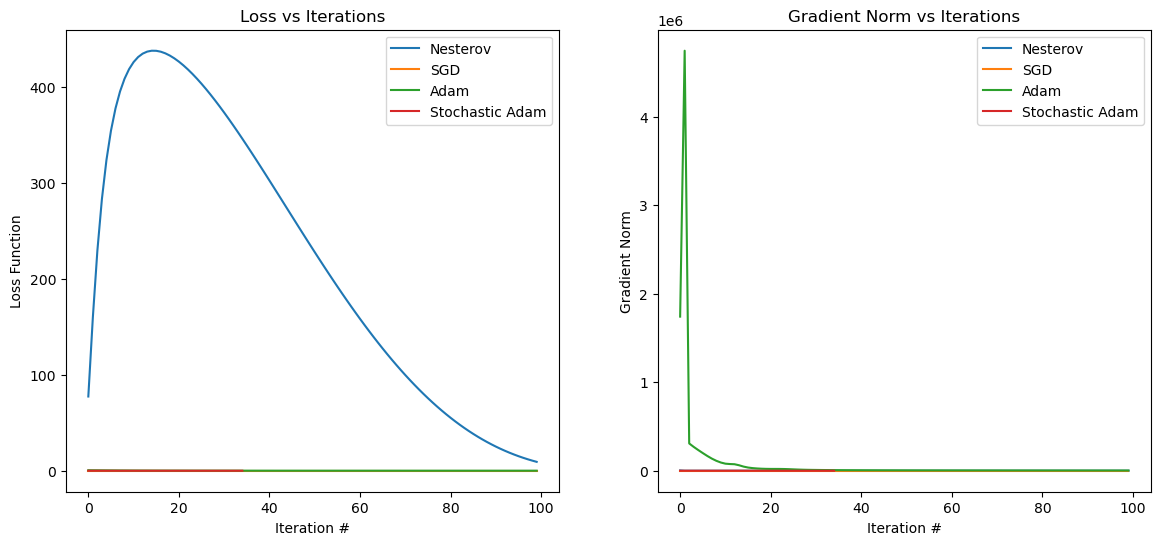

In [26]:
# Plot the loss change and gradient change of all methods
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot for Nesterov method
ax1.plot(Loss_vals, label='Nesterov')
ax1.set_title('Loss vs Iterations')
ax1.set_xlabel('Iteration #')
ax1.set_ylabel('Loss Function')
ax1.legend()

ax2.plot(gradnorm_vals, label='Nesterov')
ax2.set_title('Gradient Norm vs Iterations')
ax2.set_xlabel('Iteration #')
ax2.set_ylabel('Gradient Norm')
ax2.legend()

# Plot for SGD method
ax1.plot(Loss_vals_sgd, label='SGD')
ax1.legend()

ax2.plot(gradnorm_vals_sgd, label='SGD')
ax2.legend()

# Plot for Adam method
ax1.plot(Loss_vals_adam, label='Adam')
ax1.legend()

ax2.plot(gradnorm_vals_adam, label='Adam')
ax2.legend()

# Plot for Stochastic Adam method
ax1.plot(Loss_vals_stochastic_adam, label='Stochastic Adam')
ax1.legend()

ax2.plot(gradnorm_vals_stochastic_adam, label='Stochastic Adam')
ax2.legend()

plt.show()

In [27]:
# Define a list of batch sizes to experiment with
batch_sizes = [16, 32, 64, 128]

# Dictionary to store results for each batch size
results = {}

# Loop over each batch size
for batch_size in batch_sizes:
    print(f"Running Stochastic Adam with batch size: {batch_size}")
    w_stochastic_adam, Loss_vals_stochastic_adam, gradnorm_vals_stochastic_adam = stochastic_adam_optimizer(
        X_train, lbl_train, w_init, lam, step_size, max_epochs, batch_size, tol)
    
    # Store the results
    results[batch_size] = {
        'weights': w_stochastic_adam,
        'loss_vals': Loss_vals_stochastic_adam,
        'gradnorm_vals': gradnorm_vals_stochastic_adam
    }

# Print the results
for batch_size, result in results.items():
    print(f"Batch size: {batch_size}")
    print(f"Final Loss: {result['loss_vals'][-1]}")
    print(f"Final Gradient Norm: {result['gradnorm_vals'][-1]}")
    print()

Running Stochastic Adam with batch size: 16
Epoch 1: Loss = 0.022344, Grad Norm = 1.804703
Epoch 2: Loss = 0.034718, Grad Norm = 4.604923
Epoch 3: Loss = 0.049687, Grad Norm = 13.144368
Epoch 4: Loss = 0.035188, Grad Norm = 4.643491
Epoch 5: Loss = 0.015261, Grad Norm = 3.174779
Epoch 6: Loss = 0.042172, Grad Norm = 12.799106
Epoch 7: Loss = 0.024977, Grad Norm = 2.608672
Epoch 8: Loss = 0.032635, Grad Norm = 3.205550
Epoch 9: Loss = 0.039427, Grad Norm = 4.511932
Epoch 10: Loss = 0.027543, Grad Norm = 3.997487
Epoch 11: Loss = 0.008252, Grad Norm = 0.231882
Epoch 12: Loss = 0.008406, Grad Norm = 0.600297
Epoch 13: Loss = 0.015280, Grad Norm = 1.128443
Epoch 14: Loss = 0.013692, Grad Norm = 0.736161
Epoch 15: Loss = 0.010934, Grad Norm = 0.366206
Epoch 16: Loss = 0.005494, Grad Norm = 0.137619
Epoch 17: Loss = 0.005121, Grad Norm = 0.084899
Epoch 18: Loss = 0.007479, Grad Norm = 0.195429
Epoch 19: Loss = 0.001990, Grad Norm = 0.020278
Epoch 20: Loss = 0.004370, Grad Norm = 0.044067
Epo

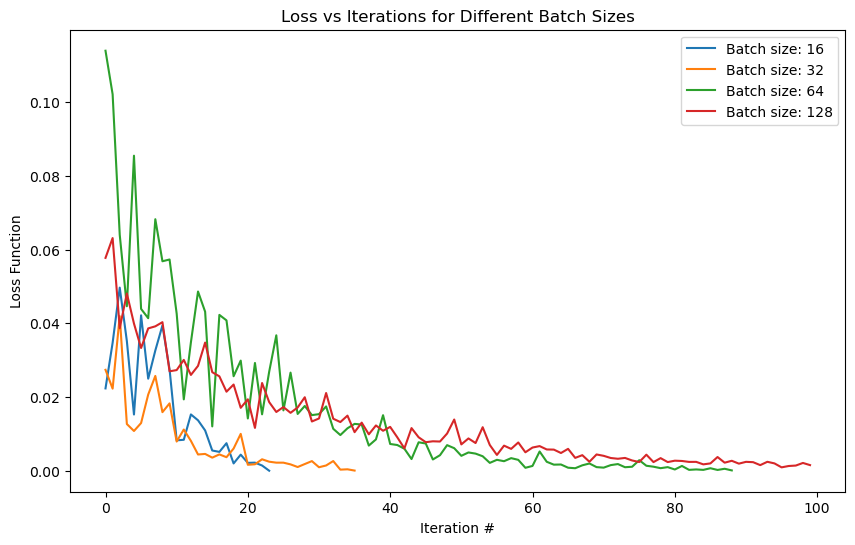

In [29]:
# Plot the loss change for different batch sizes
fig, ax = plt.subplots(figsize=(10, 6))

# Loop over each batch size and plot the loss values
for batch_size in batch_sizes:
    ax.plot(results[batch_size]['loss_vals'], label=f'Batch size: {batch_size}')

# Set plot title and labels
ax.set_title('Loss vs Iterations for Different Batch Sizes')
ax.set_xlabel('Iteration #')
ax.set_ylabel('Loss Function')
ax.legend()

# Show plot
plt.show()